In [2]:
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from luzero import calculations
import numpy
import seaborn as sms

In [2]:
url = "postgresql://{}:{}@{}:{}/{}".format('flexbox','flexbox','cosmos.niuera.co',5432,'flexbox_db_server_compiled')
con = create_engine(url,client_encoding='utf8')

In [69]:
#######################################
### Get Pre-Implementation Energy
def get_energy_pre(df_list,df_list_df):

    for df in df_list:
        print(df['hostname'].unique()[0].replace('flxbxD',''))
        energy = calculations.fix_dataframe_values(df,'true_fridge_energy')
        energy.index = energy.index - timedelta(hours=6)

        minute_resample = energy['true_fridge_energy'].resample('1T').last().interpolate(method='time')
        hour_resample = minute_resample.resample('1H').last() - minute_resample.resample('1H').first()
        hour_resample_df = pd.DataFrame(hour_resample)
        hour_resample_df['hour'] = hour_resample_df.index.hour

        hourly_average = hour_resample_df.groupby(['hour']).mean()

        #Change column name
        new_col_name = df['hostname'].unique()[0].replace('flxbxD','')
        hourly_average = hourly_average.rename(columns = {'true_fridge_energy':new_col_name})

        df_list_df.append(hourly_average)
        
    return(df_list_df)

##########################################
### Get Post-Implementation Energy
def post_energy_calc(df_list,df_list_df,df_list_fulldf):
    
    for df in df_list:
        energy = calculations.fix_dataframe_values(df,'energy_sum3')
        energy.index = energy.index - timedelta(hours=6)

        minute_resample = energy['energy_sum3'].resample('1T').last().interpolate(method='time')
        hour_resample = minute_resample.resample('1H').last() - minute_resample.resample('1H').first()
        hour_resample_df = pd.DataFrame(hour_resample)
        hour_resample_df['hour'] = hour_resample_df.index.hour
        
        new_col_name = df['hostname'].unique()[0].replace('flxbxD','')

        if new_col_name == '6':
            hour_resample_df1 = hour_resample_df[datetime(2016,7,25):datetime(2016,8,15)]
            hour_resample_df2 = hour_resample_df[datetime(2016,9,15):datetime(2016,11,1)]
            hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)
            hourly_average = hour_resample_df.groupby(['hour']).mean()
        elif new_col_name == '18':
            hour_resample_df1 = hour_resample_df[datetime(2016,7,1):datetime(2016,7,16)]
            hour_resample_df2 = hour_resample_df[datetime(2016,7,27):datetime(2016,11,1)]
            hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)
            hourly_average = hour_resample_df.groupby(['hour']).mean()
        elif new_col_name == '19':
            hour_resample_df1 = hour_resample_df[datetime(2016,7,1):datetime(2016,7,17)]
            hour_resample_df2 = hour_resample_df[datetime(2016,8,3):datetime(2016,11,1)]
            hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)
            hourly_average = hour_resample_df.groupby(['hour']).mean()
        else:
            hourly_average = hour_resample_df.groupby(['hour']).mean()

        #Change column name
        hourly_average = hourly_average.rename(columns = {'energy_sum3':new_col_name})
        df_list_df.append(hourly_average)
        df_list_fulldf.append(hour_resample_df)
        
    return(df_list_df,df_list_fulldf)


##########################################
### Get Pre-Implementation Fridge Energy Consumption
def pre_impl_fridge_energy(df_list_fridge,df_list_pre_fridge):

    for df in df_list_fridge:

        energy = calculations.fix_dataframe_values(df,'energy_sum3')
        energy.index = energy.index - timedelta(hours=6)

        minute_resample = energy['energy_sum3'].resample('1T').last().interpolate(method='time')
        hour_resample = minute_resample.resample('1H').last() - minute_resample.resample('1H').first()
        hour_resample_df = pd.DataFrame(hour_resample)
        hour_resample_df['hour'] = hour_resample_df.index.hour

        new_col_name = df['hostname'].unique()[0].replace('flxbxD','')

        if new_col_name == '6':
            hour_resample_df1 = hour_resample_df[datetime(2016,7,25):datetime(2016,8,15)]
            hour_resample_df2 = hour_resample_df[datetime(2016,9,15):datetime(2016,11,1)]
            hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)
        elif new_col_name == '18':
            hour_resample_df1 = hour_resample_df[datetime(2016,7,1):datetime(2016,7,16)]
            hour_resample_df2 = hour_resample_df[datetime(2016,7,27):datetime(2016,11,1)]
            hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)
        elif new_col_name == '19':
            hour_resample_df1 = hour_resample_df[datetime(2016,7,1):datetime(2016,7,17)]
            hour_resample_df2 = hour_resample_df[datetime(2016,8,3):datetime(2016,11,1)]
            hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)

        df_participate = all_participant_data[(all_participant_data['hostname'] == 'flxbxD1') & (all_participant_data['event_participation']>=20)]
        energy_participate = pd.merge(df_participate, hour_resample_df, left_index=True, right_index=True)

        hourly_average = energy_participate.groupby(['hour']).mean()
        subset_participation_hours = pd.DataFrame(hourly_average['energy_sum3'])
        subset_participation_hours['hostname'] = new_col_name

        df_list_pre_fridge.append(subset_participation_hours)
        
    return(df_list_pre_fridge)

In [145]:
########### Reading in Price Data
#url = "postgresql://{}:{}@{}:{}/{}".format('niuera_analyzer','analysis','162.243.146.213',5432,'cndc_hourly_db')
#con = create_engine(url,client_encoding='utf8')

#predicted_prices = pd.read_sql('predespacho',con)
#predicted_prices.to_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/cndc/hourly_gen_prices.csv')
#predicted_prices.index = pd.to_datetime(predicted_prices['datetime'])

#spot_prices = pd.read_sql('posdespacho_spot',con)
#spot_prices.to_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/cndc/hourly_spot_prices.csv')
#spot_prices.index = pd.to_datetime(spot_prices['datetime'])


#actual_prices = pd.read_sql('posdespacho_costs',con)
#actual_prices.to_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/cndc/hourly_act_prices.csv')
#actual_prices.index = pd.to_datetime(actual_prices['datetime'])


2017-08-14 22:05:55.710786


In [4]:
###### 
# Getting participation in DR events

#url = "postgresql://{}:{}@{}:{}/{}".format('flexbox','flexbox','cosmos.niuera.co',5432,'flexbox_db_server_compiled')
#con = create_engine(url,client_encoding='utf8')

#for i in range(1,2):
 #   print(datetime.now())

  #  path_import_dr = "select * from demand_response where hostname = 'flxbxD" + str(i) + "'"
   # path_export_dr = '/Users/diego/Desktop/Data/flexbox_event_analysis/dr/' + 'flxbxD'+ str(i) + '.csv'

   # df_dr = pd.read_sql(path_import_dr,con)
   # df_dr.to_csv(path_export_dr)
   # print(datetime.now())

    
#### #### #### #### 
#### Get data for participation in DR events

df_analys1 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD1.csv')
df_analys3 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD3.csv')
df_analys6 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD6.csv')
df_analys7 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD7.csv')
df_analys9 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD9.csv')
df_analys11 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD11.csv')
df_analys12 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD12.csv')
df_analys14 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD14.csv')
df_analys16 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD16.csv')
df_analys18 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD18.csv')
df_analys19 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD19.csv')
df_analys20 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD20.csv')
df_analys21 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD21.csv')
df_analys22 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD22.csv')
df_analys24 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD24.csv')
df_analys25 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD25.csv')
df_analys26 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD26.csv')
df_analys28 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD28.csv')
df_analys29 = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/flxbxD29.csv')

In [151]:
###### 
# Looking for peak shifting DR event times

#url = "postgresql://{}:{}@{}:{}/{}".format('niuera_analyzer','analysis','162.243.146.213',5432,'niuera_control_db')
#con = create_engine(url,client_encoding='utf8')

#dr_signals_peak = pd.read_sql('peak_shifting_dr',con)
#net_load_dr = pd.read_sql('net_load_dr',con)

# Read it next time you're using it
#dr_signals_peak.to_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/peak_shifting_dr.csv')
dr_signals_peak = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/dr/peak_shifting_dr.csv')
dr_signals_peak.index = pd.to_datetime(dr_signals_peak['datetime'])
event_df = dr_signals_peak[dr_signals_peak['signal'] ==1 ]
event_df['minutes'] = 60


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [5]:
for i in range(1,2):
    
    print(datetime.now())
    #Pre Implementation
    path_import_pre = "select * from fridge_power where datetime < '2016-07-01' and hostname = 'flxbxD" + str(i) + "'"
    path_export_pre = '/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/' + 'flxbxD'+ str(i) + '.csv'
    
    df_test_pre = pd.read_sql(path_import_pre,con)
    df_test_pre.to_csv(path_export_pre)
    
    #Post Implementation
    path_import_post = "select * from fridge_power where datetime >= '2016-07-01' and hostname = 'flxbxD" + str(i) + "'"
    path_export_post = '/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/' + 'flxbxD'+ str(i) + '.csv'
    
    df_test_post = pd.read_sql(path_import_post,con)
    df_test_post.to_csv(path_export_post)
    
    print(i)
    print(datetime.now())
    
    


2017-08-12 19:38:13.343516
1
2017-08-12 19:40:26.589183


In [5]:
a1_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD1.csv')
a1_pre.index = pd.to_datetime(a1_pre['datetime'])

a1_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD1.csv')
a1_post.index = pd.to_datetime(a1_post['datetime'])

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
a3_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD3.csv')
a3_pre.index = pd.to_datetime(a3_pre['datetime'])

a3_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD3.csv')
a3_post.index = pd.to_datetime(a3_post['datetime'])

In [7]:
a6_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD6.csv')
a6_pre.index = pd.to_datetime(a6_pre['datetime'])

a6_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD6.csv')
a6_post.index = pd.to_datetime(a6_post['datetime'])

In [8]:
a7_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD7.csv')
a7_pre.index = pd.to_datetime(a7_pre['datetime'])

a7_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD7.csv')
a7_post.index = pd.to_datetime(a7_post['datetime'])

In [9]:
a9_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD9.csv')
a9_pre.index = pd.to_datetime(a9_pre['datetime'])

a9_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD9.csv')
a9_post.index = pd.to_datetime(a9_post['datetime'])

In [10]:
a10_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD10.csv')
a10_pre.index = pd.to_datetime(a10_pre['datetime'])

a10_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD10.csv')
a10_post.index = pd.to_datetime(a10_post['datetime'])

In [11]:
a11_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD11.csv')
a11_pre.index = pd.to_datetime(a11_pre['datetime'])

a11_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD11.csv')
a11_post.index = pd.to_datetime(a11_post['datetime'])

In [12]:
a12_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD12.csv')
a12_pre.index = pd.to_datetime(a12_pre['datetime'])

a12_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD12.csv')
a12_post.index = pd.to_datetime(a12_post['datetime'])

In [13]:
a14_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD14.csv')
a14_pre.index = pd.to_datetime(a14_pre['datetime'])

a14_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD14.csv')
a14_post.index = pd.to_datetime(a14_post['datetime'])

In [14]:
a16_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD16.csv')
a16_pre.index = pd.to_datetime(a16_pre['datetime'])

a16_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD16.csv')
a16_post.index = pd.to_datetime(a16_post['datetime'])

In [15]:
a18_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD18.csv')
a18_pre.index = pd.to_datetime(a18_pre['datetime'])

a18_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD18.csv')
a18_post.index = pd.to_datetime(a18_post['datetime'])

In [16]:
a19_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD19.csv')
a19_pre.index = pd.to_datetime(a19_pre['datetime'])

a19_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD19.csv')
a19_post.index = pd.to_datetime(a19_post['datetime'])

In [17]:
a20_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD20.csv')
a20_pre.index = pd.to_datetime(a20_pre['datetime'])

a20_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD20.csv')
a20_post.index = pd.to_datetime(a20_post['datetime'])

In [18]:
a21_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD21.csv')
a21_pre.index = pd.to_datetime(a21_pre['datetime'])

a21_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD21.csv')
a21_post.index = pd.to_datetime(a21_post['datetime'])

In [19]:
a22_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD22.csv')
a22_pre.index = pd.to_datetime(a22_pre['datetime'])

a22_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD22.csv')
a22_post.index = pd.to_datetime(a22_post['datetime'])

In [20]:
a24_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD24.csv')
a24_pre.index = pd.to_datetime(a24_pre['datetime'])

a24_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD24.csv')
a24_post.index = pd.to_datetime(a24_post['datetime'])

In [21]:
a25_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD25.csv')
a25_pre.index = pd.to_datetime(a25_pre['datetime'])

a25_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD25.csv')
a25_post.index = pd.to_datetime(a25_post['datetime'])

In [22]:
a26_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD26.csv')
a26_pre.index = pd.to_datetime(a26_pre['datetime'])

a26_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD26.csv')
a26_post.index = pd.to_datetime(a26_post['datetime'])

In [23]:
a28_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD28.csv')
a28_pre.index = pd.to_datetime(a28_pre['datetime'])

a28_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD28.csv')
a28_post.index = pd.to_datetime(a28_post['datetime'])

In [24]:
a29_pre = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/pre_intervention/flxbxD29.csv')
a29_pre.index = pd.to_datetime(a29_pre['datetime'])

a29_post = pd.read_csv('/Users/diego/Desktop/Data/flexbox_event_analysis/post_intervention/flxbxD29.csv')
a29_post.index = pd.to_datetime(a29_post['datetime'])

In [25]:
########## 
# Pre-Implementation

#A1
first = a1_pre[a1_pre['active_pwr2']>500].head(1).index[0]
last = a1_pre[a1_pre['active_pwr2']>500].tail(1).index[0]

sub1 = a1_pre[first:last]
sub1['true_fridge_power'] = sub1['active_pwr2']
sub1['true_fridge_energy'] = sub1['energy_sum2']

#A3
sub3 = a3_pre
sub3['true_fridge_power'] = sub3['active_pwr2']
sub3['true_fridge_energy'] = sub3['energy_sum2']

#A6
sub6 = a6_pre[datetime(2015,7,1):datetime(2016,1,20)]
sub6['true_fridge_power'] = sub6['active_pwr3']
sub6['true_fridge_energy'] = sub6['energy_sum3']

#A7
sub7 = a7_pre
sub7['true_fridge_power'] = sub7['active_pwr3']
sub7['true_fridge_energy'] = sub7['energy_sum3']

#A9
sub9 = a9_pre
sub9['true_fridge_power'] = sub9['active_pwr3']
sub9['true_fridge_energy'] = sub9['energy_sum3']

#A10
sub10 = a10_pre
sub10['true_fridge_power'] = sub10['active_pwr3']
sub10['true_fridge_energy'] = sub10['energy_sum3']

#A11
sub11 = a11_pre[datetime(2016,5,1):datetime(2016,8,1)]
sub11['true_fridge_power'] = sub11['active_pwr3']
sub11['true_fridge_energy'] = sub11['energy_sum3']

#A12
sub12 = a12_pre
sub12['true_fridge_power'] = sub12['active_pwr3']
sub12['true_fridge_energy'] = sub12['energy_sum3']

#A14
sub14 = a14_pre
sub14['true_fridge_power'] = sub14['active_pwr3']
sub14['true_fridge_energy'] = sub14['energy_sum3']

#A16
sub16 = a16_pre
sub16['true_fridge_power'] = sub16['active_pwr3']
sub16['true_fridge_energy'] = sub16['energy_sum3']

#A18
sub18 = a18_pre
sub18['true_fridge_power'] = sub18['active_pwr3']
sub18['true_fridge_energy'] = sub18['energy_sum3']

#A19
sub19 = a19_pre
sub19['true_fridge_power'] = sub19['active_pwr3']
sub19['true_fridge_energy'] = sub19['energy_sum3']

#A20
sub20 = a20_pre
sub20['true_fridge_power'] = sub20['active_pwr3']
sub20['true_fridge_energy'] = sub20['energy_sum3']

#A21
sub21 = a21_pre[datetime(2016,2,15):datetime(2016,8,1)]
sub21['true_fridge_power'] = sub21['active_pwr3']
sub21['true_fridge_energy'] = sub21['energy_sum3']

#A22
sub22 = a22_pre
sub22['true_fridge_power'] = sub22['active_pwr3']
sub22['true_fridge_energy'] = sub22['energy_sum3']

#A22
sub24 = a24_pre
sub24['true_fridge_power'] = sub24['active_pwr3']
sub24['true_fridge_energy'] = sub24['energy_sum3']

#A25
sub25 = a25_pre
sub25['true_fridge_power'] = sub25['active_pwr3']
sub25['true_fridge_energy'] = sub25['energy_sum3']

#A26
sub26 = a26_pre
sub26['true_fridge_power'] = sub26['active_pwr3']
sub26['true_fridge_energy'] = sub26['energy_sum3']

#A28
sub28 = a28_pre
sub28['true_fridge_power'] = sub28['active_pwr3']
sub28['true_fridge_energy'] = sub28['energy_sum3']

#A29
sub29 = a29_pre
sub29['true_fridge_power'] = sub29['active_pwr3']
sub29['true_fridge_energy'] = sub29['energy_sum3']



/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [26]:
########## 
# Post-Implementation

sub1_post = a1_post[datetime(2016,7,1):datetime(2016,11,1)]
sub3_post = a3_post[datetime(2016,7,1):datetime(2016,11,1)]

sub6_post = a6_post[datetime(2016,7,1):datetime(2016,11,1)]
#sub6_post1 = a6_post[datetime(2016,7,25):datetime(2016,8,15)]
#sub6_post2 = a6_post[datetime(2016,9,15):datetime(2016,11,1)]
#sub6_post = pd.concat([sub6_post1,sub6_post2],axis=1)

sub7_post = a7_post[datetime(2016,7,1):datetime(2016,11,1)]
sub9_post = a9_post[datetime(2016,7,1):datetime(2016,11,1)]
sub11_post = a11_post[datetime(2016,7,1):datetime(2016,11,1)]
sub12_post = a12_post[datetime(2016,7,1):datetime(2016,11,1)]
sub14_post = a14_post[datetime(2016,7,1):datetime(2016,11,1)]
sub16_post = a16_post[datetime(2016,7,1):datetime(2016,10,25)]

sub18_post = a18_post[datetime(2016,7,1):datetime(2016,11,1)]
#sub18_post1 = a18_post[datetime(2016,7,1):datetime(2016,7,16)]
#sub18_post2 = a18_post[datetime(2016,7,27):datetime(2016,11,1)]
#sub18_post = pd.concat([sub18_post1,sub18_post2],axis=1)

sub19_post = a19_post[datetime(2016,7,1):datetime(2016,11,1)]
#sub19_post1 = a19_post[datetime(2016,7,1):datetime(2016,7,17)]
#sub19_post2 = a19_post[datetime(2016,8,3):datetime(2016,11,1)]
#sub19_post = pd.concat([sub19_post1,sub19_post2],axis=1)

sub20_post = a20_post[datetime(2016,7,1):datetime(2016,11,1)]
sub21_post = a21_post[datetime(2016,7,1):datetime(2016,11,1)]
sub22_post = a22_post[datetime(2016,7,1):datetime(2016,9,8)]
sub24_post = a24_post[datetime(2016,7,1):datetime(2016,11,1)]
sub25_post = a25_post[datetime(2016,7,1):datetime(2016,9,18)]
sub26_post = a26_post[datetime(2016,7,1):datetime(2016,11,1)]
sub28_post = a28_post[datetime(2016,7,1):datetime(2016,11,1)]
sub29_post = a29_post[datetime(2016,7,1):datetime(2016,11,1)]


In [33]:
### Get Energy from Pre-Implementation Data
df_list = [sub1,sub3,sub6,sub7,sub9,sub11,sub12,sub14,sub16,sub18,sub19,sub20,sub21,sub22,sub24,sub25,sub26,sub28,sub29]
df_list_df = []

df_list_df = get_energy_pre(df_list,df_list_df)

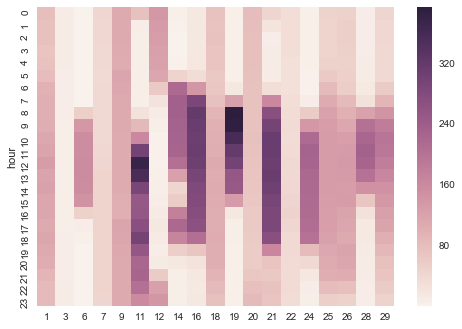

In [34]:
concatenate_pre = pd.concat(df_list_df,axis=1)
sms.set(font="Arial")
heat_map_pre = sms.heatmap(concatenate_pre)


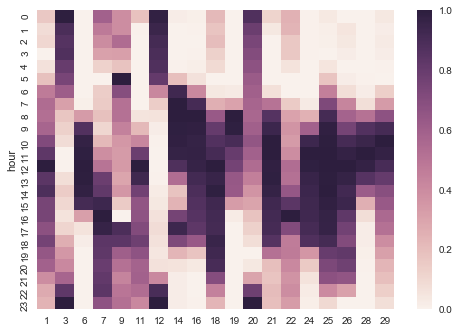

In [442]:
col_names = ['1','3','6','7','9','11','12','14','16','18','19','20','21','22','24','25','26','28','29']

norm_df = concatenate_pre

for col in col_names:
    norm_df[col] = norm_df[col].apply(lambda x:(x-min(norm_df[col]))/(max(norm_df[col])-min(norm_df[col])))

sms.set(font="Arial")
heat_map_pre_norm = sms.heatmap(norm_df)

In [ ]:
energy = calculations.fix_dataframe_values(df,'energy_sum3')
energy.index = energy.index - timedelta(hours=6)

minute_resample = energy['energy_sum3'].resample('1T').last().interpolate(method='time')
hour_resample = minute_resample.resample('1H').last() - minute_resample.resample('1H').first()
hour_resample_df = pd.DataFrame(hour_resample)
hour_resample_df['hour'] = hour_resample_df.index.hour

new_col_name = df['hostname'].unique()[0].replace('flxbxD','')

if new_col_name == '6':
    hour_resample_df1 = hour_resample_df[datetime(2016,7,25):datetime(2016,8,15)]
    hour_resample_df2 = hour_resample_df[datetime(2016,9,15):datetime(2016,11,1)]
    hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)
    hourly_average = hour_resample_df.groupby(['hour']).mean()
elif new_col_name == '18':
    hour_resample_df1 = hour_resample_df[datetime(2016,7,1):datetime(2016,7,16)]
    hour_resample_df2 = hour_resample_df[datetime(2016,7,27):datetime(2016,11,1)]
    hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)
    hourly_average = hour_resample_df.groupby(['hour']).mean()
elif new_col_name == '19':
    hour_resample_df1 = hour_resample_df[datetime(2016,7,1):datetime(2016,7,17)]
    hour_resample_df2 = hour_resample_df[datetime(2016,8,3):datetime(2016,11,1)]
    hour_resample_df = pd.concat([hour_resample_df1,hour_resample_df2],axis=0)
    hourly_average = hour_resample_df.groupby(['hour']).mean()
else:
    hourly_average = hour_resample_df.groupby(['hour']).mean()

#Change column name
hourly_average = hourly_average.rename(columns = {'energy_sum3':new_col_name})
df_list_df.append(hourly_average)
df_list_fulldf.append(hour_resample_df)

return(df_list_df,df_list_fulldf)

In [435]:
### Get Energy from Post-Implementation Data

df_list = [sub1_post,sub3_post,sub6_post,sub7_post,sub9_post,sub11_post,sub12_post,sub14_post,sub16_post,sub18_post,sub19_post,sub20_post,sub21_post,sub22_post,sub24_post,sub25_post,sub26_post,sub28_post,sub29_post]
df_list_df = []
        
df_list_df_post = post_energy_calc(df_list,df_list_df)

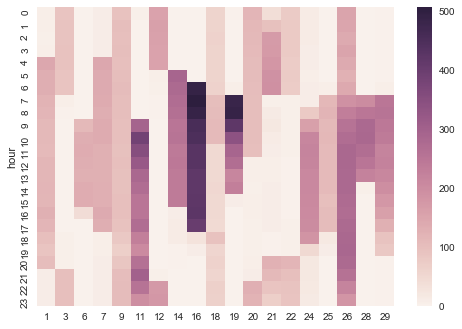

In [436]:
concatenate_post = pd.concat(df_list_df_post,axis=1)
sms.set(font="Arial")
heat_map_post = sms.heatmap(concatenate_post)

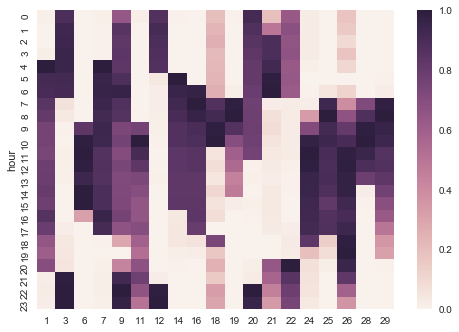

In [437]:
col_names = ['1','3','6','7','9','11','12','14','16','18','19','20','21','22','24','25','26','28','29']

norm_df_post = concatenate_post

for col in col_names:
    norm_df_post[col] = norm_df_post[col].apply(lambda x:(x-min(norm_df_post[col]))/(max(norm_df_post[col])-min(norm_df_post[col])))

sms.set(font="Arial")
heat_map_pre_norm = sms.heatmap(norm_df_post)

In [43]:
######## Analysis for those that were available and participated in the events
### Calculating % participation per hour for each flexbox id and the number of minutes that they participated in each event

df_list_participate = [df_analys1,df_analys3,df_analys6,df_analys7,df_analys9,df_analys11,df_analys12,df_analys14,df_analys16,df_analys18,df_analys19,df_analys20,df_analys21,df_analys22,df_analys25,df_analys28,df_analys29]
df_list_frames = []
all_participants_df = pd.DataFrame()

for df in df_list_participate:
    
    #Getting only the times when it was receiving a server signal
    df.index = pd.to_datetime(df['datetime']) - timedelta(hours=6)
    little_flexbox_server = df[df['control_source'] == 'server']

    little_flexbox_server['event_participation'] = 1-little_flexbox_server['mfi_state']
    little_minute_resample = little_flexbox_server['event_participation'].resample('1T').mean()
    little_hour_resample = little_minute_resample.resample('1H').sum()
    little_hour_resample_df = pd.DataFrame(little_hour_resample)
    little_hour_resample_df['hostname'] = little_flexbox_server['hostname'].values[0]
    df_list_frames.append(little_hour_resample_df)
    
    
all_participant_data = pd.concat(df_list_frames,axis=0)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [169]:
participation_time = pd.merge(all_participant_data, event_df, left_index=True, right_index=True)
participation_time['pct_available'] = (participation_time['event_participation']/participation_time['minutes'])*100

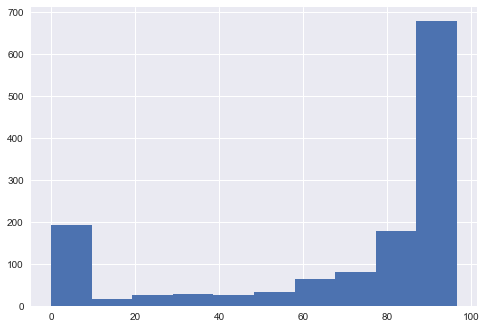

In [170]:
# Distribution of % participation time per event
participation_time['pct_available'].hist()

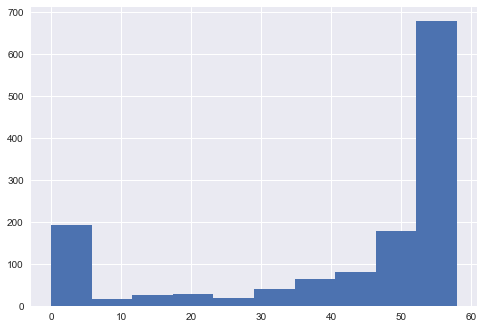

In [171]:
# Distribution of % participation minutes per event
participation_time['event_participation'].hist()

In [172]:
#### Grouping by date and calculating the median % participation

participation_time['hour'] = participation_time.index.hour
participation_time['date'] = participation_time.index.date
hourly_average = participation_time.groupby(['date','hour']).median()
hourly_average.reset_index()

heatmap_df_participate = pd.pivot_table(hourly_average,values='event_participation',index=['hour'],columns=['date'],fill_value=0)
heatmap_df_pct = pd.pivot_table(hourly_average,values='pct_available',index=['hour'],columns=['date'],fill_value=0)



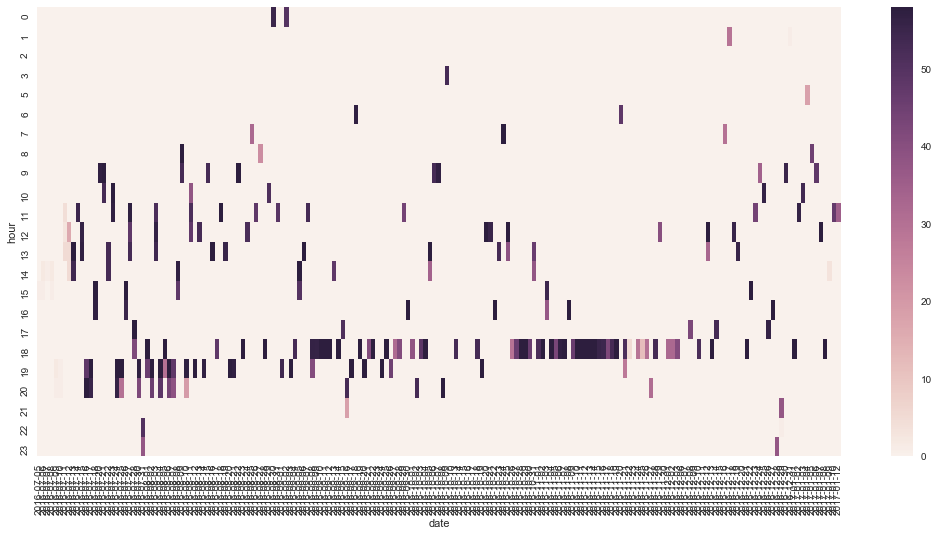

In [173]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)
sms.set(font="Arial")
heat_map_pre_norm = sms.heatmap(heatmap_df_participate)

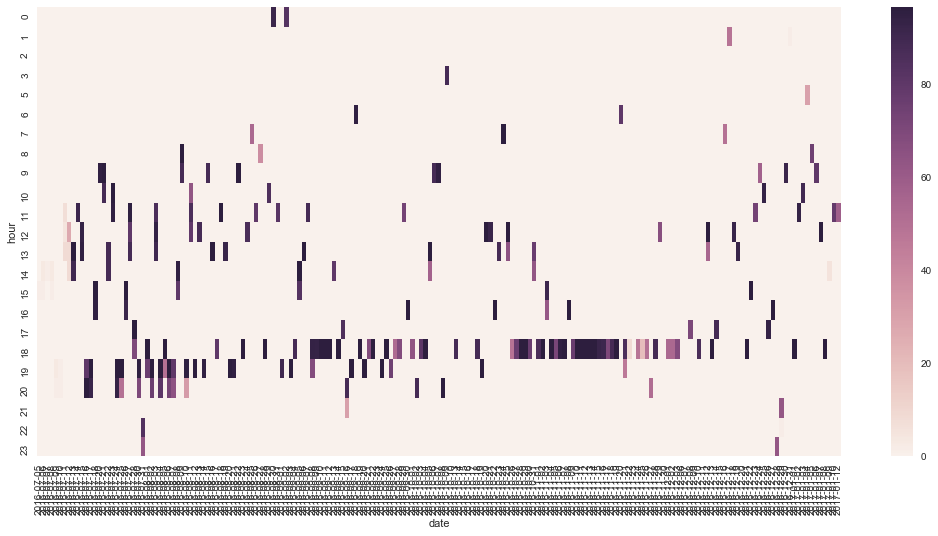

In [179]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)

sms.set(font="Arial")
heat_map_pre_norm = sms.heatmap(heatmap_df_pct)

In [148]:
######## Analysis for calculating the amount of time that people would be available to participate
# They would be available if
# lost_connection_to_server: time calculate
# lost_connection_to_mfi: time calculate
# max_temp_limit_reached: calculate
# server: calculate

df_list_participate = [df_analys1,df_analys3,df_analys6,df_analys7,df_analys9,df_analys11,df_analys12,df_analys14,df_analys16,df_analys18,df_analys19,df_analys20,df_analys21,df_analys22,df_analys25,df_analys28,df_analys29]
df_list_available_frames = []
all_participants_df = pd.DataFrame()

for df in df_list_participate:
    
    #Getting only the times when it was receiving a server signal
    df.index = pd.to_datetime(df['datetime']) - timedelta(hours=6)
    
    little_flexbox_available = df
    little_flexbox_available['availability'] = 1
    little_flexbox_available.loc[little_flexbox_available['control_source'] == 'required_to_be_off','availability'] = 0
    little_flexbox_available_hour = little_flexbox_available['availability'].resample('1H').max().fillna(0)
    little_flexbox_available_hour_df = pd.DataFrame(little_flexbox_available_hour)
    little_flexbox_available_hour_df['hostname'] = df['hostname'].values[0]
    df_list_available_frames.append(little_flexbox_available_hour_df)
    print(df['hostname'].values[0])
    
all_available_data = pd.concat(df_list_available_frames,axis=0)

flxbxD1
flxbxD3
flxbxD6
flxbxD7
flxbxD9
flxbxD11
flxbxD12
flxbxD14
flxbxD16
flxbxD18
flxbxD19
flxbxD20
flxbxD21
flxbxD22
flxbxD25
flxbxD28
flxbxD29


In [176]:
available_time = pd.merge(all_available_data, event_df, left_index=True, right_index=True)

available_time['hour'] = available_time.index.hour
available_time['date'] = available_time.index.date

hourly_participants = available_time.groupby(['date','hour']).sum()
hourly_participants_pct = hourly_participants

heatmap_df_participants = pd.pivot_table(hourly_participants,values='availability',index=['hour'],columns=['date'],fill_value=0)


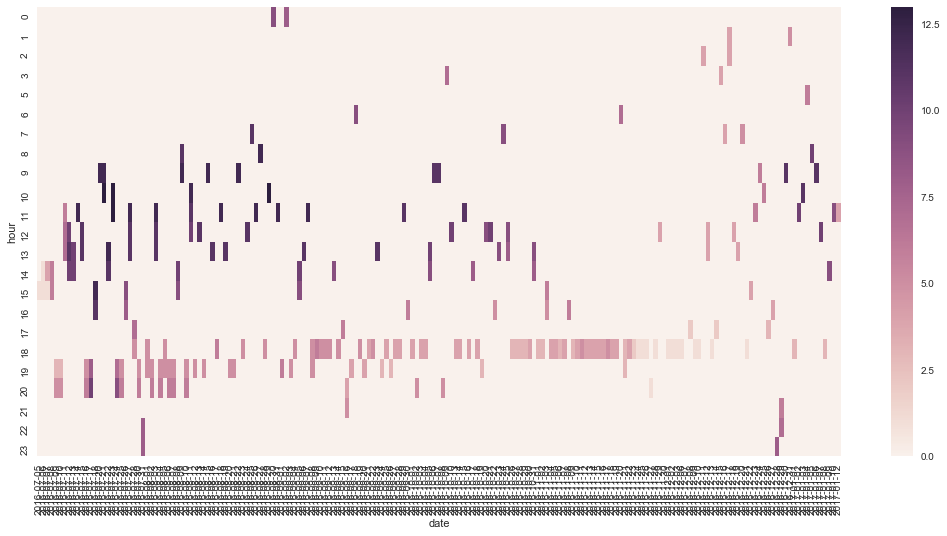

In [177]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)
sms.set(font="Arial")
heat_map_particpants = sms.heatmap(heatmap_df_participants)

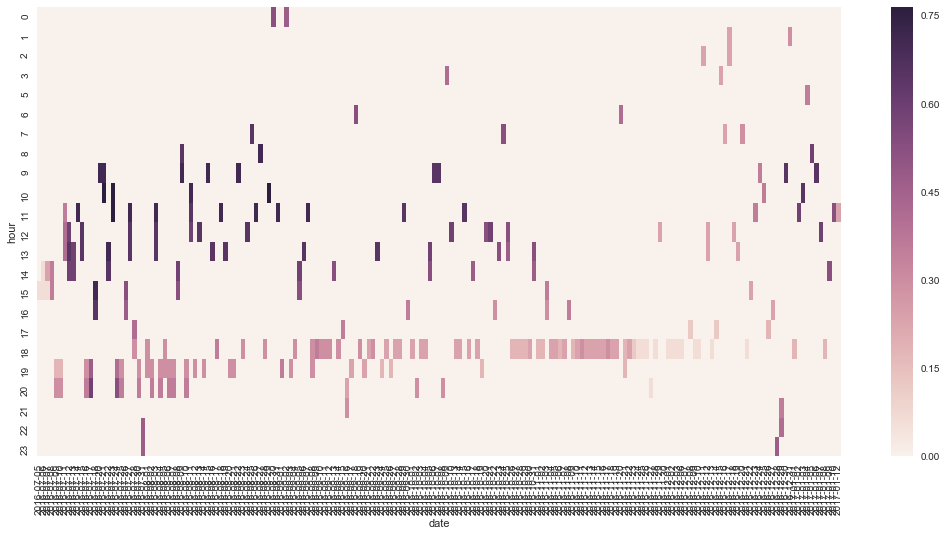

In [178]:
hourly_participants_pct['availability'] = hourly_participants_pct['availability']/17.0
hourly_participants_pct = pd.pivot_table(hourly_participants_pct,values='availability',index=['hour'],columns=['date'],fill_value=0)

fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)
sms.set(font="Arial")
heat_map_particpants_pct = sms.heatmap(hourly_participants_pct)

In [65]:
#######
# Getting Pre-Implementation for Every Fridge

df_list_fridge = [sub1_post,sub3_post,sub6_post,sub7_post,sub9_post,sub11_post,sub12_post,sub14_post,sub16_post,sub18_post,sub19_post,sub20_post,sub21_post,sub22_post,sub25_post,sub28_post,sub29_post]
df_list_pre_fridge = []

energy_fridge_pre = pre_impl_fridge_energy(df_list_fridge,df_list_pre_fridge)
energy_fridge_pre_df = pd.concat(energy_fridge_pre,axis=0)
energy_fridge_pre_df['hour'] = energy_fridge_pre_df.index

In [66]:
# Putting together with hours where they were previously consuming energy

In [128]:

concatenate_pre
concatenate_pre['hour'] = concatenate_pre.index
melt_pre_fridge = pd.melt(concatenate_pre, id_vars=['hour'])
melt_pre_fridge = melt_pre_fridge.rename(columns={'variable':'hostname'})

melt_pre_fridge_df = pd.merge(energy_fridge_pre_df,melt_pre_fridge,on=['hour','hostname'])
melt_pre_fridge_df['energy_diff'] = melt_pre_fridge_df['energy_sum3'] - melt_pre_fridge_df['value']
melt_pre_fridge_df['energy_pct'] = (melt_pre_fridge_df['energy_diff']/melt_pre_fridge_df['value'])

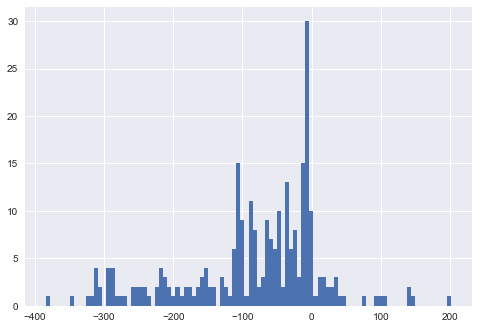

In [129]:
melt_pre_fridge_df['energy_diff'].hist(bins=100)

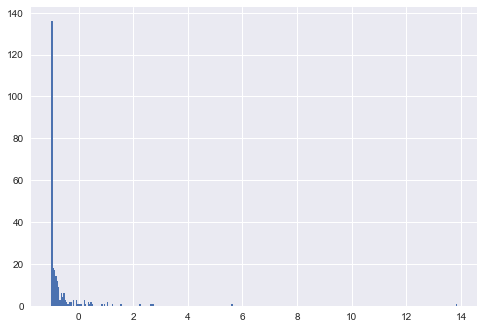

In [130]:
melt_pre_fridge_df['energy_pct'].hist(bins=300)

In [181]:
melt_pre_fridge_df.mean()

energy_sum3     27.639551
hostname              inf
hour            12.490637
value          111.376574
energy_diff    -83.737022
energy_pct      -0.638531
dtype: float64

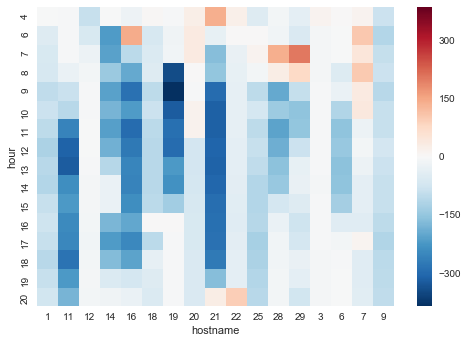

In [131]:
#### Heat Map of Energy Reduction Consumption by Hour

energy_diff_heat = melt_pre_fridge_df[['hostname','hour','energy_diff']]
energy_diff_heat_pv =  pd.pivot_table(energy_diff_heat,values='energy_diff',index=['hour'],columns=['hostname'],fill_value=0)

sms.set(font="Arial")
map_energy_diff_heat_pv = sms.heatmap(energy_diff_heat_pv)

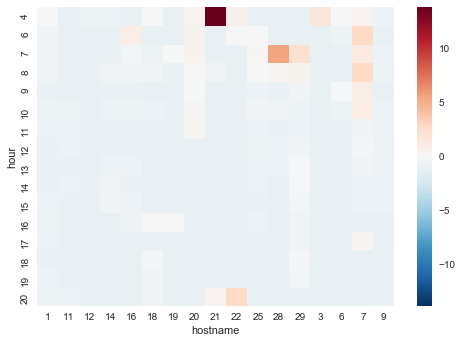

In [132]:
#### Heat Map of Energy Reduction Consumption by Hour

energy_diff_heat_pct = melt_pre_fridge_df[['hostname','hour','energy_pct']]
energy_diff_heat_pv_pct =  pd.pivot_table(energy_diff_heat_pct,values='energy_pct',index=['hour'],columns=['hostname'],fill_value=0)

sms.set(font="Arial")
map_energy_diff_heat_pct = sms.heatmap(energy_diff_heat_pv_pct)

In [137]:
#############
## Price Analysis


In [164]:

predicted_prices['hour'] = predicted_prices.index.hour
predicted_prices['date'] = predicted_prices.index.date

predicted_prices = predicted_prices[datetime(2016,6,1):datetime(2016,11,1)]
heatmap_df_pred_prices_df = pd.pivot_table(predicted_prices,values='LIQ',index=['hour'],columns=['date'],fill_value=0)


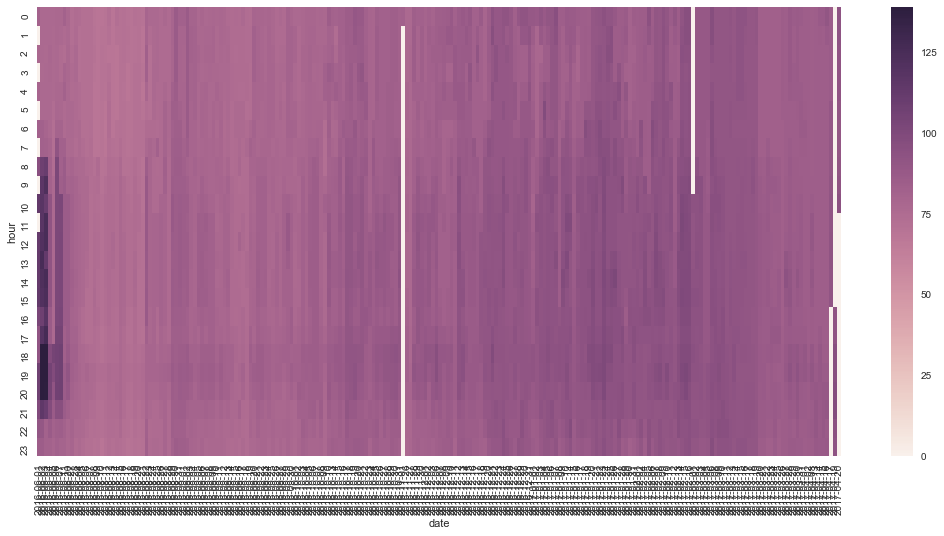

In [165]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)
sms.set(font="Arial")
heatmap_df_pred_prices = sms.heatmap(heatmap_df_pred_prices_df)

In [166]:

heatmap_df_pred_prices_df_norm = heatmap_df_pred_prices_df
col_names = heatmap_df_pred_prices_df.keys()

for col in col_names:
    heatmap_df_pred_prices_df_norm[col] = heatmap_df_pred_prices_df_norm[col].apply(lambda x:(x-min(heatmap_df_pred_prices_df_norm[col]))/(max(heatmap_df_pred_prices_df_norm[col])-min(heatmap_df_pred_prices_df_norm[col])))


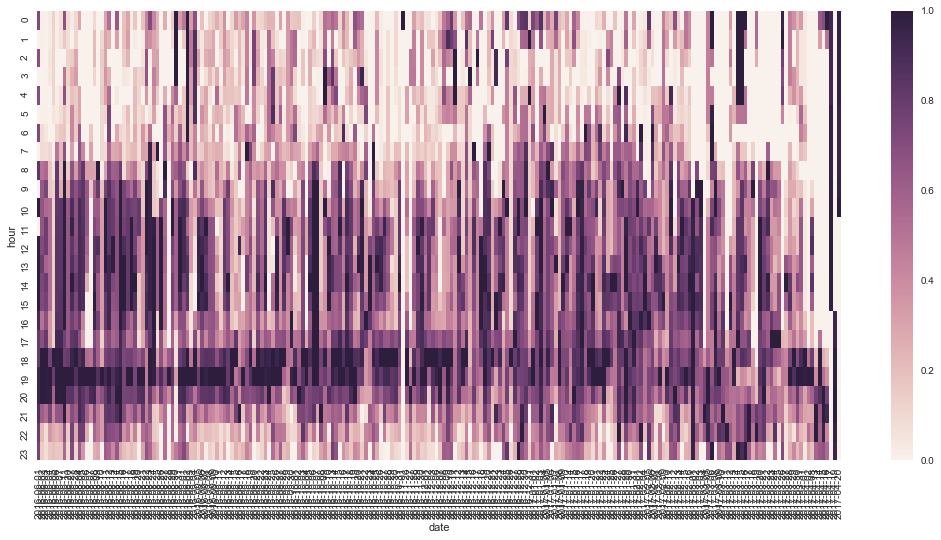

In [167]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)
sms.set(font="Arial")
sms.heatmap(heatmap_df_pred_prices_df_norm)